In [ ]:
!pip install parameter-sherpa pandas numpy

In [2]:
import numpy as np
import pandas as pd
import sherpa
%display typeset

In [3]:
CA_POP = 14810000

In [4]:
def model(t, y, params):
    S, E, I, A, H, R = y
    chi, phi, beta, rho, delta, gamma, alpha, mu, p, q, r = params
    lamb = beta * (I + A)
    
    if (t < q or t > q + r):
        chi = 0
    
    return [
        -lamb * ((1 - chi) * S),                   # 0 dS/dt
        lamb * ((1 - chi) * S) - alpha * E,        # 1 dE/dt
        (1 - p) * alpha * E - delta * I - phi * I, # 2 dI/dt
        p * alpha * E - gamma * A,                 # 3 dA/dt
        phi * I - (rho + mu) * H,                  # 4 dH/dt
        delta * I + rho * H + gamma * A,           # 5 dR/dt
    ]

In [5]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

O = ode_solver()
O.function = model
O.algorithm = 'rk4'
inits = [.99, 0, 0, 1e-5, 0, 0]

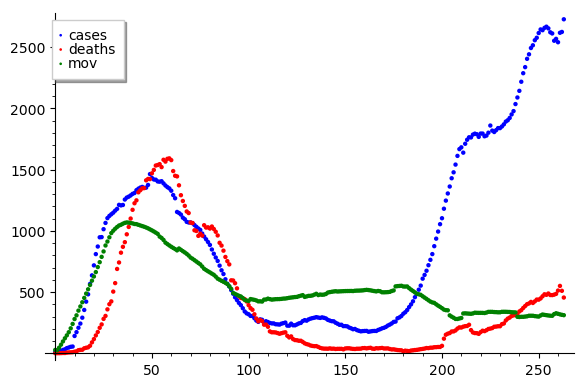

In [6]:
dfCA = pd.read_pickle("data.pkl")
LEN = len(dfCA)
a = list_plot(dfCA["cases"],     color='blue',  legend_label="cases")
b = list_plot(dfCA["deaths"]*10, color='red',   legend_label="deaths")
c = list_plot(dfCA["mov"]*20,    color='green', legend_label="mov")
show(a+b+c)

In [7]:
PARAM = ['chi', 'phi', 'beta', 'rho', 'delta', 'gamma', 'alpha', 'mu', 'p', 'q', 'r']
parameters = [
    sherpa.Continuous(name='chi'  ,range=[0.8,0.999]), #
    sherpa.Continuous(name='phi'  ,range=[0.003,0.005]), #
    sherpa.Continuous(name='beta' ,range=[0.27,0.29]), #
    sherpa.Continuous(name='rho'  ,range=[0.2,1]),
    sherpa.Continuous(name='delta',range=[0.01,1]),
    sherpa.Continuous(name='gamma',range=[0.01,1]),
    sherpa.Continuous(name='alpha',range=[0.19,0.22]), #
    sherpa.Continuous(name='mu'   ,range=[0.01,.7]),
    sherpa.Continuous(name='p'    ,range=[0.01,.7]),
    sherpa.Discrete  (name='q'    ,range=[1,30]),
    sherpa.Discrete  (name='r'    ,range=[120,150]), #
    sherpa.Discrete  (name='t0'   ,range=[0,25]), #
]

TRIALS = 300
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=TRIALS)

study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

trial = study.get_suggestion()
trial.parameters

{'chi': 0.9961946976932636,
 'phi': 0.0030837285099540234,
 'beta': 0.2838035605636725,
 'rho': 0.25751237864456356,
 'delta': 0.24414601345015252,
 'gamma': 0.6905735568139809,
 'alpha': 0.19888839731325036,
 'mu': 0.05600143695103701,
 'p': 0.5879122596431278,
 'q': 18,
 'r': 127,
 't0': 10}

In [8]:
i = 0

for trial in study:
    
    if (i % 10 == 0):
        print(f"{i} ", end="")
    i += 1
    
    t0 = trial.parameters['t0']
    pars = [trial.parameters[n] for n in PARAM]

    O.ode_solve([0, t0+LEN], inits, num_points=t0+LEN, params=pars)
    sim = get_sim_array(O.solution)
    
    I = sim[t0 : t0 + LEN, 2] * CA_POP
    H = sim[t0 : t0 + LEN, 4] * CA_POP
        
    phi = trial.parameters["phi"]
    mu = trial.parameters["mu"]
    
    lic = list(dfCA.cases)
    lid = list(dfCA.deaths)
    
    loss = ( sum((dfCA.cases-phi*I)**2) + sum((dfCA.deaths-mu*H)**2) )/(2*LEN)
    #loss = (lic[60] - phi*I[60]) ** 2 + (lic[150] - phi*I[150]) ** 2 + (lic[250] - phi*I[250]) ** 2
    
    study.add_observation(trial=trial, objective=loss)
    study.finalize(trial)

res = study.get_best_result()
res

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

{'Trial-ID': 56,
 'Iteration': 1,
 'alpha': 0.2118549440182517,
 'beta': 0.28003917150384344,
 'chi': 0.8209875874387444,
 'delta': 0.39519196366793397,
 'gamma': 0.022135223760784684,
 'mu': 0.04959468455139117,
 'p': 0.5112175118089008,
 'phi': 0.003056407250844303,
 'q': 29,
 'r': 135,
 'rho': 0.6492872419691673,
 't0': 20,
 'Objective': 453491.4039010883}

In [9]:
def plot_results(result):
    pars = [result[n] for n in PARAM]
    phi = result['phi']
    mu = result['mu']
    t0 = result['t0']
    O.ode_solve([0, t0+LEN], inits, num_points=t0+LEN, params=pars)
    sim = get_sim_array(O.solution) * CA_POP
    i   = list_plot(phi*sim[:LEN+t0,2],color='red',legend_label='New. cases', plotjoined=True)
    #h   = list_plot(sim[:LEN+t0,4],color='purple', legend_label='New. Deaths', plotjoined=True)
    cc  = list_plot(list(zip(range(t0,LEN+t0),dfCA.cases)), color='black',legend_label='cases (obs)')
    #cd  = list_plot(list(zip(range(t0,LEN+t0),dfCA.deaths)), color='orange',legend_label='deaths(obs)')
    #show(i + h + cc + cd)
    show(i + cc)

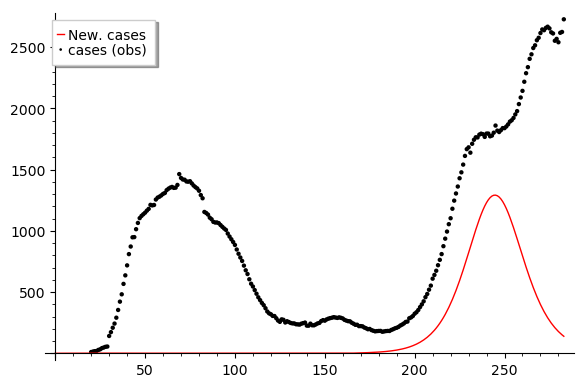

In [10]:
plot_results(res)

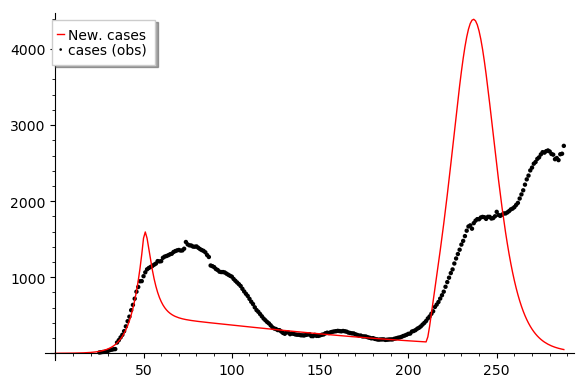

In [40]:
resu["beta"] = 0.6
resu["phi"] = 0.02
resu["delta"] = 0.7
resu["alpha"] = 0.2
resu["gamma"] = 0.03
resu["t0"] = 25
resu["r"] = 160
resu["q"] = 50
resu["chi"] = 0.9
resu["p"] = 0.5
plot_results(resu)

In [30]:
resu = res

beta = 0.28
phi = 0.004
alpha = 0.2

r = 150
q = 40
chi   = 0.880